In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pickle
import avocado
import seaborn as sns


sns.set_theme(style="whitegrid")
plt.style.use('seaborn')
%matplotlib inline

In [2]:
plot_labels_extra_short = {
    6: 'Single $\mu$-lens',
    15: 'TDE',
    16: 'Eclip. Binary',
    42: 'SNII',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
    99: 'Unknown',
}

type_ids = plot_labels_extra_short.keys()

In [3]:
dataset = avocado.load("plasticc_train")
metadata = dataset.metadata

In [4]:
labels = metadata["class"].to_numpy()
classes = np.unique(labels)
class_count = defaultdict(int)
for l in labels:
    class_count[l]+=1

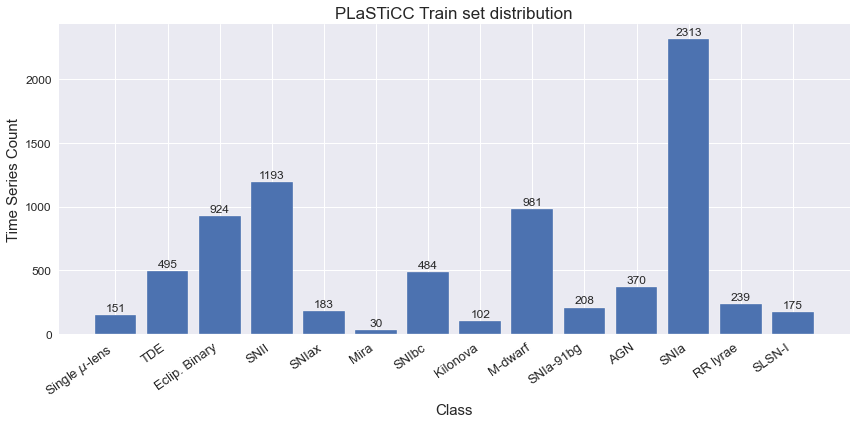

In [5]:
def plot_labels(class_count, title="PLaSTiCC Train set distribution", filename="train-set-dist.png"):
    labels_cc, values_cc = zip(*sorted(class_count.items()))
    labels_keys = [plot_labels_extra_short[x] for x in labels_cc]
    indexes = np.arange(len(labels_cc))
    fig, ax = plt.subplots(figsize=(12, 6))
    r = ax.bar(indexes, values_cc)
    plt.xticks(indexes, labels_keys, rotation = 35, ha="right", fontsize=13)
    plt.yticks(fontsize=12)
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Time Series Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 15,
                    '%d' % int(height),
                    ha='center', va='bottom', fontsize=12)
    
    autolabel(r)
    plt.tight_layout()
    plt.savefig("figs/%s" % filename, dpi=300)
            
    
    
plot_labels(class_count)

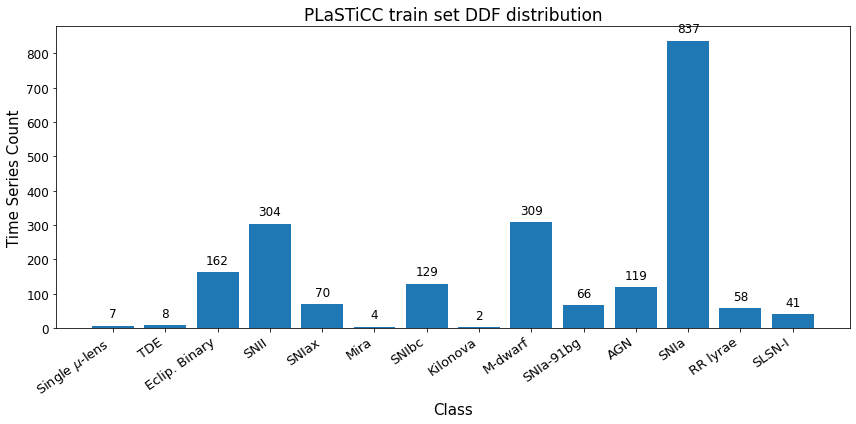

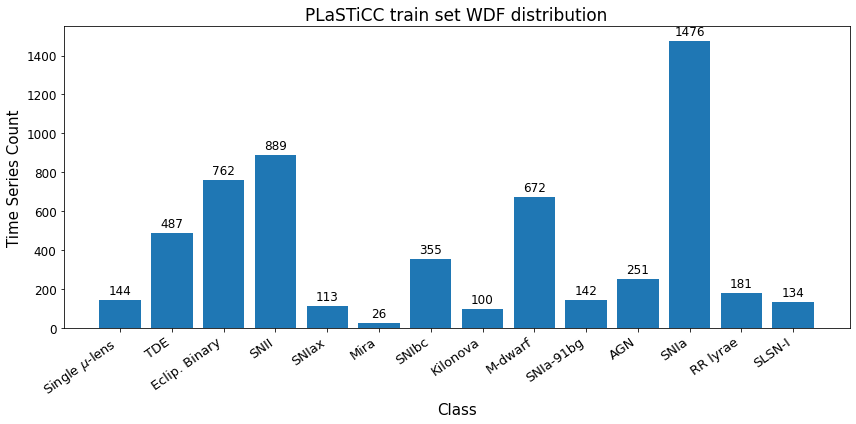

In [61]:

labels = metadata["class"].to_numpy()
ddf = metadata["ddf"].to_numpy()
classes = np.unique(labels)
class_count_ddf = defaultdict(int)
class_count_wdf = defaultdict(int)
for i in range(len(labels)):
    l = labels[i]
    ddf_val = ddf[i]
    if ddf_val == 1:
        class_count_ddf[l] += 1
    else:
        class_count_wdf[l] += 1
        
plot_labels(class_count_ddf, title="PLaSTiCC train set DDF distribution", filename="augment_set_ddf_dist.png")
plot_labels(class_count_wdf, title="PLaSTiCC train set WDF distribution", filename="augment_set_wdf_dist.png")

# histogram of augmented dataset

In [6]:
dataset_augment = avocado.load("plasticc_augment_v3", metadata_only=True)
metadata_augment = dataset_augment.metadata

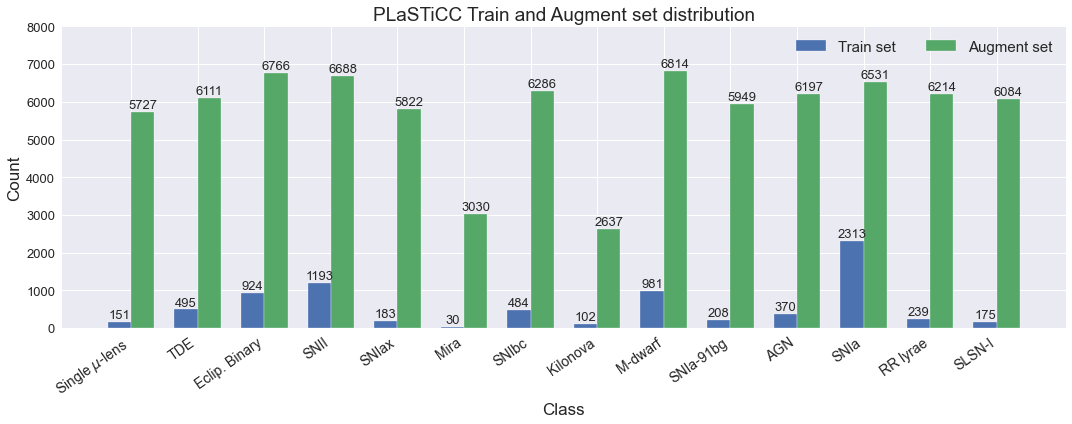

In [30]:
labels_augment = metadata_augment["class"].to_numpy()
classes_augment = np.unique(labels_augment)
class_count_augment = defaultdict(int)

for l in labels_augment:
    class_count_augment[l]+=1
# plot_labels(class_count, title="PLaSTiCC augmented train set distribution", filename="augment_set_dist.png")

def plot_labels_tuple(class_count1, class_count2, label1, label2, title="Multi-band Time Series count per class"):
    labels_cc1, values_cc1 = zip(*sorted(class_count1.items()))
    labels_cc2, values_cc2 = zip(*sorted(class_count2.items()))
    
    indexes = np.arange(len(labels_cc1))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(15, 6))
    
    rects1 = ax.bar(indexes, values_cc1, width)
    rects2 = ax.bar(indexes + 0.35, values_cc2, width)
    
#     ax.set_xticks(indexes + width / 2)
#     ax.set_ylim([0, max(np.max(values_cc1), np.max(values_cc2)) + 150])
#     ax.set_xticklabels(labels_cc1)
    labels_keys = [plot_labels_extra_short[x] for x in labels_cc1]
    plt.xticks(indexes + width / 2, labels_keys, rotation = 35, ha="right", fontsize=14)
    plt.yticks(fontsize=13)
    ax.set_ylim([0, 8000])
    
    ax.set_xlabel("Class", fontsize=17)
    ax.set_ylabel("Count", fontsize=17)
    ax.set_title(title, fontsize=19)
    
    ax.legend((rects1[0], rects2[0]), (label1, label2), fontsize=15, ncol=2)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 20,
                    '%d' % int(height),
                    ha='center', va='bottom', fontsize=13)

    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    
plot_labels_tuple(class_count, class_count_augment, "Train set", "Augment set", title="PLaSTiCC Train and Augment set distribution")
plt.savefig("plasticc_train_and_augment_set_dist.png", dpi=300)

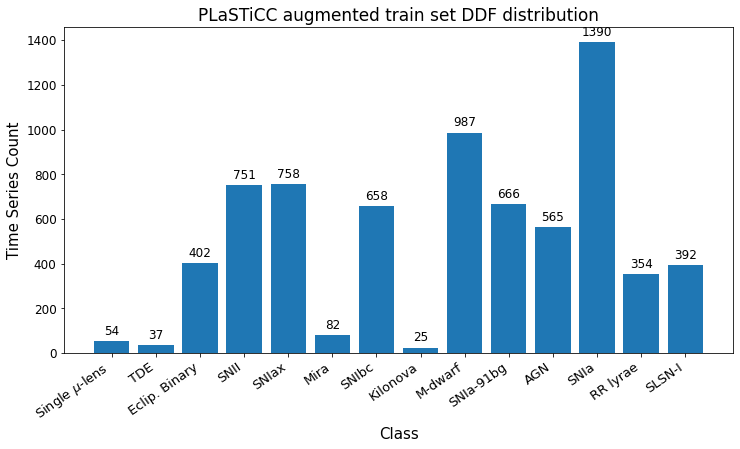

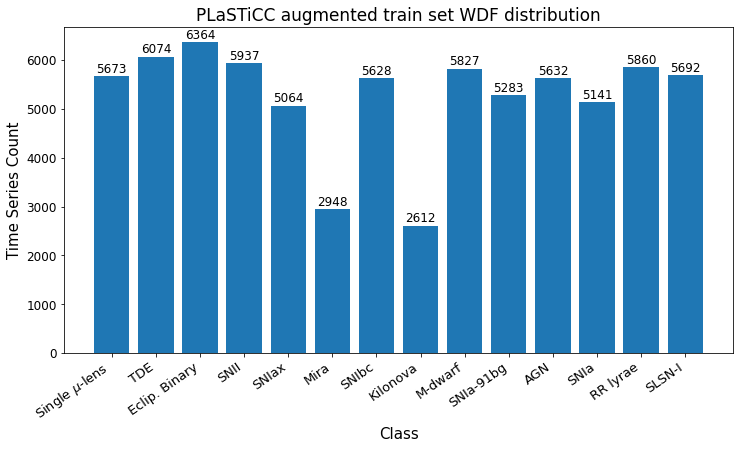

In [12]:
dataset = avocado.load("plasticc_augment_v3", metadata_only=True)
metadata = dataset.metadata
labels = metadata["class"].to_numpy()
ddf = metadata["ddf"].to_numpy()
classes = np.unique(labels)
class_count_ddf = defaultdict(int)
class_count_wdf = defaultdict(int)
for i in range(len(labels)):
    l = labels[i]
    ddf_val = ddf[i]
    if ddf_val == 1:
        class_count_ddf[l] += 1
    else:
        class_count_wdf[l] += 1
        
plot_labels(class_count_ddf, title="PLaSTiCC augmented train set DDF distribution", filename="augment_set_ddf_dist.png")
plot_labels(class_count_wdf, title="PLaSTiCC augmented train set WDF distribution", filename="augment_set_wdf_dist.png")

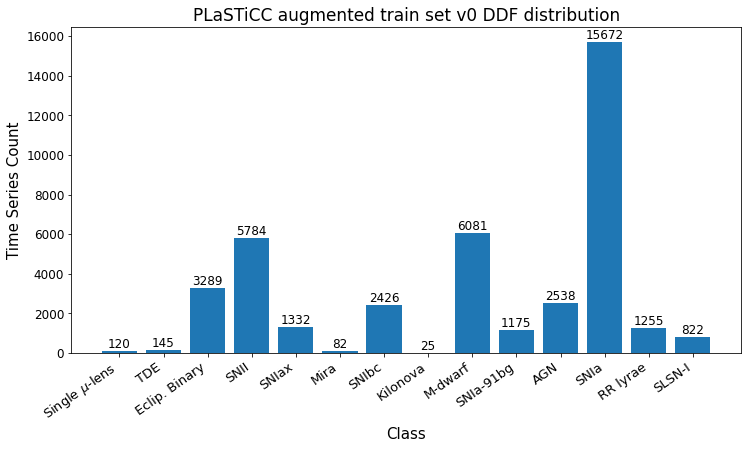

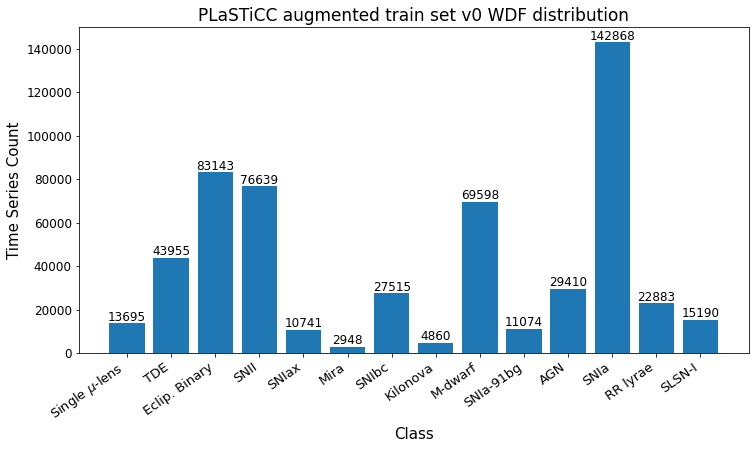

In [15]:
dataset = avocado.load("plasticc_augment", metadata_only=True)
metadata = dataset.metadata
labels = metadata["class"].to_numpy()
ddf = metadata["ddf"].to_numpy()
classes = np.unique(labels)
class_count_ddf = defaultdict(int)
class_count_wdf = defaultdict(int)
for i in range(len(labels)):
    l = labels[i]
    ddf_val = ddf[i]
    if ddf_val == 1:
        class_count_ddf[l] += 1
    else:
        class_count_wdf[l] += 1
        
plot_labels(class_count_ddf, title="PLaSTiCC augmented train set v0 DDF distribution", filename="augment_set_v0_ddf_dist.png")
plot_labels(class_count_wdf, title="PLaSTiCC augmented train set v0 WDF distribution", filename="augment_set_v0_wdf_dist.png")

In [5]:
# Note: any calls to this for the training or test sets will
# work if you rerun anything. However, augmented objects are generated
# with an element of randomness, so they won't be the same if rerunning
# all the code.
# CODE EXTRACTED FROM KBOONE/AVOCADO GITHUB (MODIFIED)
def plasticc_paper_plot(dataset, object_id, start_time=None, end_time=None,
                        min_flux=None, max_flux=None, title=None, plot_name=None, fix_scale=None, legend_loc=1):
    fig, axis = plt.subplots(figsize=(5,4))
    try:
        dataset.plot_light_curve(object_id=object_id, axis=axis)
    except avocado.AvocadoError:
        print("No object found with object_id=%s! Skipping!" % object_id)
        return
    
    axis.set_xlim(start_time, end_time)
    axis.set_ylim(min_flux, max_flux)
    
    if title is not None:
        axis.set_title(title)
    
    axis.set_xlabel('MJD (days)', fontsize=12)
    axis.set_ylabel("Flux", fontsize=12)
    axis.legend(loc=legend_loc, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if fix_scale:
        axis.ticklabel_format(axis='y', scilimits=(fix_scale, fix_scale))
    else:
        axis.ticklabel_format(axis='y', scilimits=(0,3))
    
    obj = dataset.get_object(object_id=object_id)
    
    if obj.metadata['ddf']:
        survey = 'DDF'
    else:
        survey = 'WFD'
        
    if 'reference_object_id' not in obj.metadata \
        or pd.isnull(obj.metadata['reference_object_id']):
        augment_str = ''
    else:
        augment_str = 'Augmented, '
        
    redshift = obj.metadata['redshift']
        
    axis.set_title('%s%s survey, type SNII' % (augment_str, survey), fontsize=13)
    
    fig.tight_layout()
    
    fig.savefig('./figs/gp_%s.png' % plot_name, dpi=350)

In [6]:
metadata[(metadata["ddf"]==0) & (metadata["class"]==42)].index

Index(['plasticc_001107992', 'plasticc_001150736', 'plasticc_001231534',
       'plasticc_001237057', 'plasticc_001306267', 'plasticc_001366732',
       'plasticc_001594469', 'plasticc_001744454', 'plasticc_001797009',
       'plasticc_001950799',
       ...
       'plasticc_129237530', 'plasticc_129259953', 'plasticc_129311413',
       'plasticc_129336792', 'plasticc_129546183', 'plasticc_129554871',
       'plasticc_130231675', 'plasticc_130319749', 'plasticc_130552230',
       'plasticc_130659834'],
      dtype='object', name='object_id', length=889)

In [7]:
metadata[(metadata["ddf"]==1) & (metadata["class"]==42)].index

Index(['plasticc_000000730', 'plasticc_000001632', 'plasticc_000002103',
       'plasticc_000002300', 'plasticc_000003285', 'plasticc_000004132',
       'plasticc_000004220', 'plasticc_000005527', 'plasticc_000007033',
       'plasticc_000009936',
       ...
       'plasticc_000332985', 'plasticc_000333741', 'plasticc_000334749',
       'plasticc_000334851', 'plasticc_000335148', 'plasticc_000336215',
       'plasticc_000337635', 'plasticc_000339282', 'plasticc_000339705',
       'plasticc_000341653'],
      dtype='object', name='object_id', length=304)

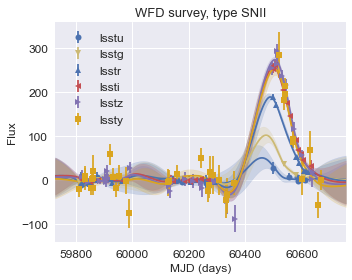

In [8]:
# start_time = 59940
start_time = None
# end_time = 60090
end_time = None
# min_flux=-45
min_flux=None
# max_flux=270
max_flux=None

plasticc_paper_plot(dataset, 'plasticc_001231534', start_time, end_time, min_flux, max_flux, plot_name='snii_wdf', legend_loc=2)

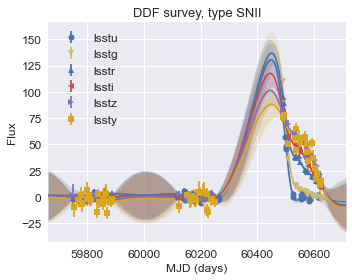

In [9]:
# start_time = 59940
start_time = None
# end_time = 60090
end_time = None
# min_flux=-45
min_flux=None
# max_flux=270
max_flux=None

plasticc_paper_plot(dataset, 'plasticc_000336215', start_time, end_time, min_flux, max_flux, plot_name='snii_ddf', legend_loc=2)

## number of observations per time series

In [11]:
metadata[metadata["ddf"]==1].index.to_numpy()

array(['plasticc_000000615', 'plasticc_000000713', 'plasticc_000000730',
       ..., 'plasticc_000342659', 'plasticc_000342819',
       'plasticc_000342844'], dtype=object)

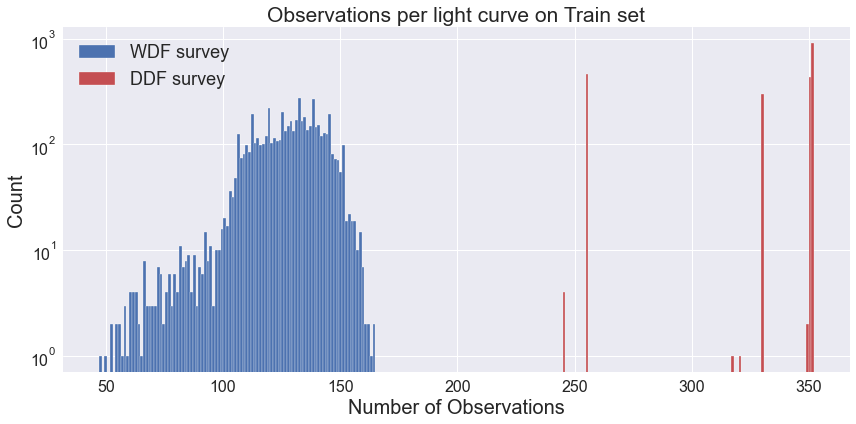

In [17]:
counts = {}
for o in dataset.objects:
    counts[o.metadata["object_id"]] = len(o.observations)
    
ddf_ids = metadata[metadata["ddf"]==1].index.to_numpy()
wdf_ids = metadata[metadata["ddf"]==0].index.to_numpy()

counts_ddf = [counts[x] for x in ddf_ids]
counts_wdf = [counts[x] for x in wdf_ids]

fig, ax = plt.subplots(figsize=(12, 6))
_ = ax.hist(counts_wdf, bins=100, label="WDF survey", log=True)
_ = ax.hist(counts_ddf, bins=100, label="DDF survey", log=True, color="r")

ax.legend(fontsize=18)
ax.set_xlabel("Number of Observations", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title("Observations per light curve on Train set", fontsize=21)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

fig.tight_layout()
    
fig.savefig('./figs/observations_per_lightcurve.png', dpi=350)

# Time window on each time series.

In [11]:
windows_ddf = []
windows_wdf = []
for o in dataset.objects:
    times = o.observations["time"]
    ddf = o.metadata["ddf"]
    w = np.max(times)-np.min(times)
    if ddf:
        windows_ddf.append(w)
    else:
        windows_wdf.append(w)

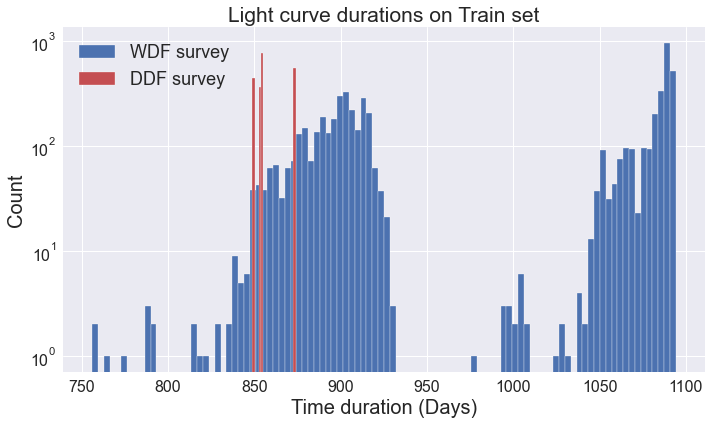

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(windows_wdf, bins=100, label="WDF survey", log=True)
ax.hist(windows_ddf, bins=20, label="DDF survey", log=True, color="r")

ax.legend(fontsize=18)
ax.set_xlabel("Time duration (Days)", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title("Light curve durations on Train set", fontsize=21)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

fig.tight_layout()

fig.savefig('./figs/light_curve_durations.png', dpi=350)

# observation intervals

In [13]:
intervals_ddf = np.array([])
intervals_wdf = np.array([])
for o in dataset.objects:
    times = o.observations["time"].to_numpy()
    times = np.sort(times)
    time_intervals = times[1:] - times[:-1]
    ddf = o.metadata["ddf"]
    if ddf:
        intervals_ddf = np.append(intervals_ddf, time_intervals)
    else:
        intervals_wdf = np.append(intervals_wdf, time_intervals)

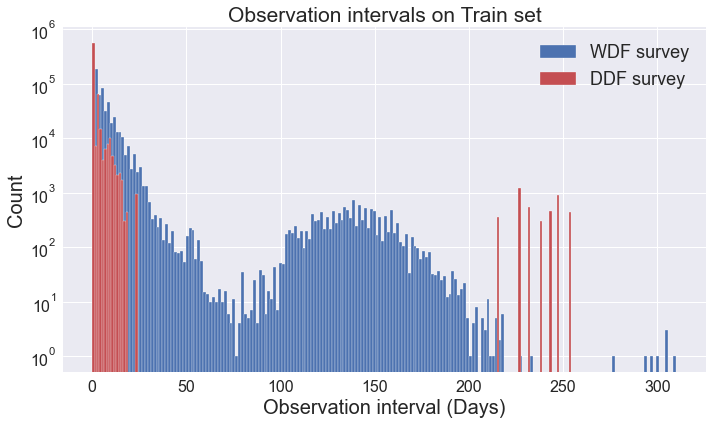

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
log = True
ax.hist(intervals_wdf, bins=200, label="WDF survey", log=log)
ax.hist(intervals_ddf, bins=200, label="DDF survey", log=log, color="r")

ax.legend(fontsize=18)
ax.set_xlabel("Observation interval (Days)", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title("Observation intervals on Train set", fontsize=21)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.tight_layout()

fig.savefig('./figs/observations_intervarls.png', dpi=350)

(0.0, 50.0)

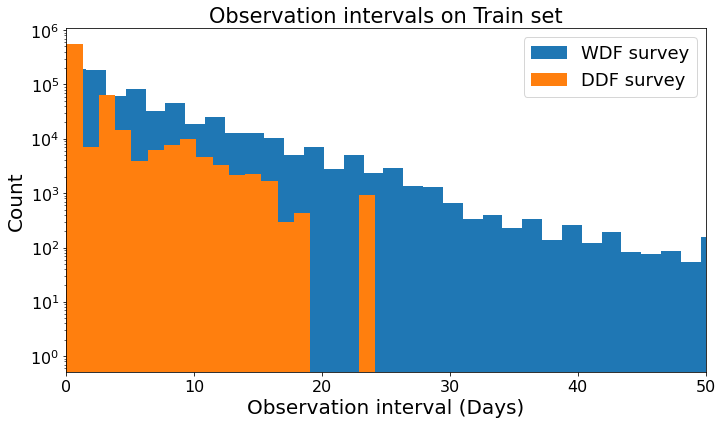

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
log = True
ax.hist(intervals_wdf, bins=200, label="WDF survey", log=log)
ax.hist(intervals_ddf, bins=200, label="DDF survey", log=log)

ax.legend(fontsize=18)
ax.set_xlabel("Observation interval (Days)", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title("Observation intervals on Train set", fontsize=21)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.tight_layout()
plt.xlim([0,50])

In [101]:
np.min(intervals_ddf)

0.005700000001525041

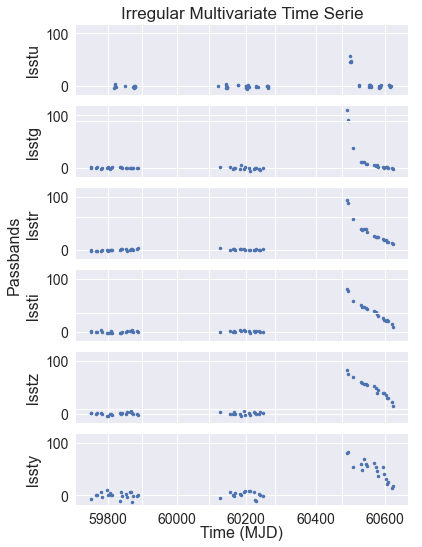

In [6]:
# obj_id = "plasticc_001231534"
obj_id = "plasticc_000336215"
obj = dataset.get_object(object_id=obj_id)
fig, ax = plt.subplots(6, 1, figsize=(6, 8), sharex=True, sharey=True)
for i, b in enumerate(obj.bands):
    df = obj.observations[obj.observations["band"]==b]
    ax[i].plot(df["time"], df["flux"], ".")
    ax[i].set_ylabel(b, fontsize=16)
    ax[i].yaxis.set_tick_params(labelsize=14)
    ax[i].xaxis.set_tick_params(labelsize=14)
    
# ax[0].set_title("Example Irregular Multivariate Time Series")
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time (MJD)", fontsize=16)
plt.title("Irregular Multivariate Time Serie", fontsize=17)
# plt.ylabel("Variables (BANDS)")
fig.text(0.03, 0.55, 'Passbands', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.savefig("figs/irregularMBTSExample.png", dpi=300)

In [7]:
for i in range(6):
    print(i % 3, i % 2)

0 0
1 1
2 0
0 1
1 0
2 1


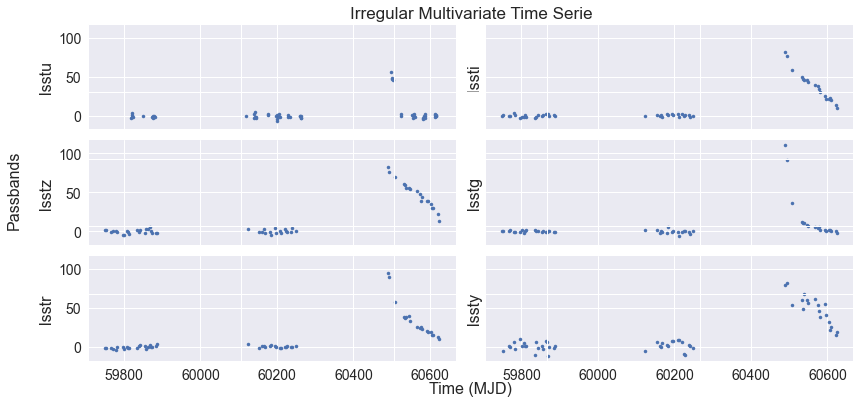

In [11]:
# obj_id = "plasticc_001231534"
obj_id = "plasticc_000336215"
obj = dataset.get_object(object_id=obj_id)
fig, ax = plt.subplots(3, 2, figsize=(12, 6), sharex=True, sharey=True)
for k, b in enumerate(obj.bands):
    i = k % 3
    j = k % 2
    df = obj.observations[obj.observations["band"]==b]
    ax[i][j].plot(df["time"], df["flux"], ".")
    ax[i][j].set_ylabel(b, fontsize=16)
    ax[i][j].yaxis.set_tick_params(labelsize=14)
    ax[i][j].xaxis.set_tick_params(labelsize=14)
    
# ax[0].set_title("Example Irregular Multivariate Time Series")
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time (MJD)", fontsize=16)
plt.title("Irregular Multivariate Time Serie", fontsize=17)
# plt.ylabel("Variables (BANDS)")
fig.text(0.0, 0.55, 'Passbands', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.savefig("figs/irregularMBTSExample2.png", dpi=300)

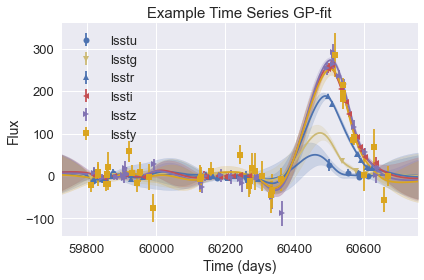

In [19]:
obj_id = "plasticc_001231534"
# obj_id = "plasticc_000336215"
obj = dataset.get_object(object_id=obj_id)
obj.plot_light_curve(show_gp=True, subtract_bacqkground=True)
plt.title("Example Time Series GP-fit", fontsize=15)
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("Flux", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig("figs/gp-fit-example.png", dpi=300)
# obj.plot_light_curve(show_gp=True, subtract_background=False)
# obj.bands

In [16]:
obj.subtract_background()

,object_id,time,flux,flux_error,detected,band
677921,plasticc_000336215,59750.4229,-0.934911,1.511671,0,lsstr
677922,plasticc_000336215,59750.4306,0.386190,2.117960,0,lsstg
677923,plasticc_000336215,59750.4383,-0.262117,2.309421,0,lssti
677924,plasticc_000336215,59750.4450,1.664488,10.346990,0,lsstz
677925,plasticc_000336215,59752.4070,-1.602577,1.069109,0,lsstr
...,...,...,...,...,...,...
678268,plasticc_000336215,60624.1760,10.735093,1.684640,1,lsstr
678269,plasticc_000336215,60624.1836,-2.616609,2.298025,0,lsstg
678270,plasticc_000336215,60624.1913,9.085924,2.198503,1,lssti
678271,plasticc_000336215,60624.2022,13.351309,3.031625,1,lsstz


In [17]:
obj.observations

,object_id,time,flux,flux_error,detected,band
677921,plasticc_000336215,59750.4229,-0.870984,1.511671,0,lsstr
677922,plasticc_000336215,59750.4306,0.610886,2.117960,0,lsstg
677923,plasticc_000336215,59750.4383,-0.124909,2.309421,0,lssti
677924,plasticc_000336215,59750.4450,1.728073,10.346990,0,lsstz
677925,plasticc_000336215,59752.4070,-1.538650,1.069109,0,lsstr
...,...,...,...,...,...,...
678268,plasticc_000336215,60624.1760,10.799020,1.684640,1,lsstr
678269,plasticc_000336215,60624.1836,-2.391913,2.298025,0,lsstg
678270,plasticc_000336215,60624.1913,9.223132,2.198503,1,lssti
678271,plasticc_000336215,60624.2022,13.414894,3.031625,1,lsstz


# number of time series with data on each band

In [136]:
dataset.objects[0].observations

,object_id,time,flux,flux_error,detected,band
0,plasticc_000000615,59750.4229,-544.810303,3.622952,1,lsstr
1,plasticc_000000615,59750.4306,-816.434326,5.553370,1,lsstg
2,plasticc_000000615,59750.4383,-471.385529,3.801213,1,lssti
3,plasticc_000000615,59750.4450,-388.984985,11.395031,1,lsstz
4,plasticc_000000615,59752.4070,-681.858887,4.041204,1,lsstr
...,...,...,...,...,...,...
347,plasticc_000000615,60624.1760,552.150269,3.917989,1,lsstr
348,plasticc_000000615,60624.1836,607.047668,5.140991,1,lsstg
349,plasticc_000000615,60624.1913,296.946533,3.475000,1,lssti
350,plasticc_000000615,60624.2022,235.489929,3.926538,1,lsstz


In [143]:
counts = defaultdict(int)
plasticc_bands = ["lsstu", "lsstg", "lsstr", "lssti", "lsstz", "lssty"]

for o in dataset.objects:
    for b in np.unique(o.observations["band"]):
        counts[b] += 1
counts

defaultdict(int,
            {'lsstg': 7848,
             'lssti': 7848,
             'lsstr': 7848,
             'lsstu': 7848,
             'lssty': 7848,
             'lsstz': 7848})

In [147]:
counts_test = defaultdict(int)
for chunk in range(100):
    print("chunks: %d/%d" % (chunk, 100), end="\r")
    test_set = avocado.load("plasticc_test", chunk=chunk, num_chunks=100)
    for o in test_set.objects:
        for b in np.unique(o.observations["band"]):
            counts_test[b] += 1
            
print(counts_test)

defaultdict(<class 'int'>, {'lsstg': 3492890, 'lssti': 3492890, 'lsstr': 3492890, 'lsstu': 3492890, 'lssty': 3492890, 'lsstz': 3492890})


In [148]:
counts_aug = defaultdict(int)
for chunk in range(100):
    print("chunks: %d/%d" % (chunk, 100), end="\r")
    test_set = avocado.load("plasticc_augment_v3", chunk=chunk, num_chunks=100)
    for o in test_set.objects:
        for b in np.unique(o.observations["band"]):
            counts_aug[b] += 1
            
print(counts_aug)

defaultdict(<class 'int'>, {'lsstg': 80852, 'lssti': 80856, 'lsstr': 80856, 'lsstu': 80855, 'lssty': 80855, 'lsstz': 80856})


In [140]:
def plot_bands_hist(class_count, title="PLaSTiCC Train set passband distribution"):
    labels_cc, values_cc = zip(*sorted(class_count.items()))
    labels_keys = labels_cc
    indexes = np.arange(len(labels_cc))
    fig, ax = plt.subplots(figsize=(12, 6))
    r = ax.bar(indexes, values_cc)
    plt.xticks(indexes, labels_keys, rotation = 35, ha="right", fontsize=13)
    plt.yticks(fontsize=12)
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Time Series Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 15,
                    '%d' % int(height),
                    ha='center', va='bottom', fontsize=12)
    
    autolabel(r)
    plt.savefig("figs/train_set_bands_dist.png", dpi=300)

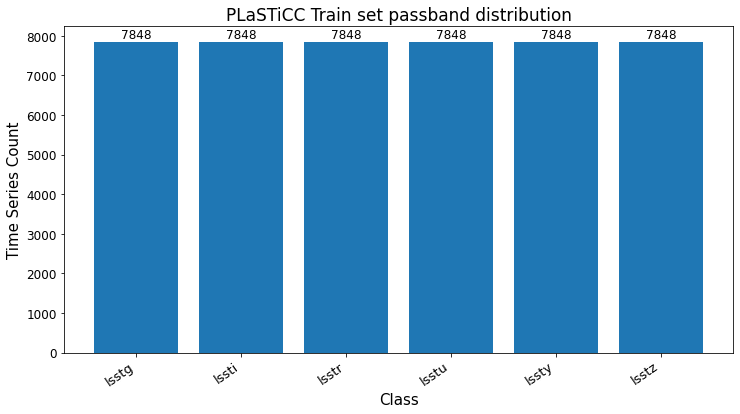

In [141]:
plot_bands_hist(counts)

## DDF vs WDF observations

In [5]:
df_meta.groupby(by=["ddf"])["ddf"].count()

ddf
0    5732
1    2116
Name: ddf, dtype: int64

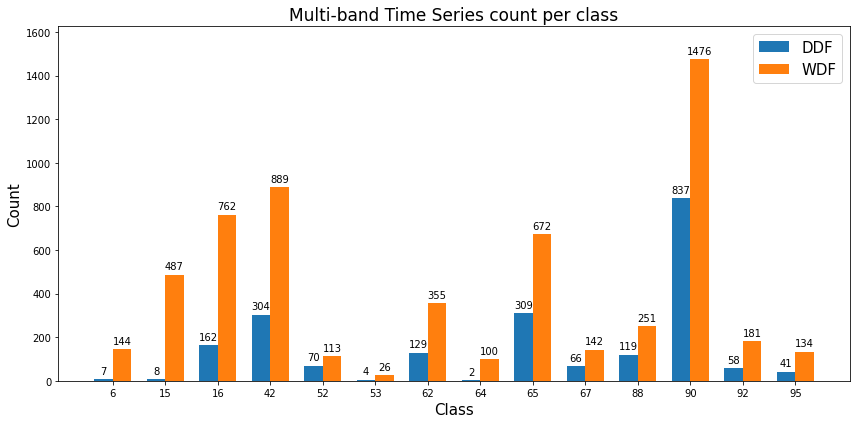

In [6]:
wdf = 0
ddf = 1

df_meta_ddf = df_meta[df_meta["ddf"] == ddf]
df_meta_wdf = df_meta[df_meta["ddf"] == wdf]

class_count_ddf = defaultdict(int)
for l in df_meta_ddf["target"]:
    class_count_ddf[l] += 1

class_count_wdf = defaultdict(int)
for l in df_meta_wdf["target"]:
    class_count_wdf[l] += 1

def plot_labels_tuple(class_count1, class_count2, label1, label2, title="Multi-band Time Series count per class"):
    labels_cc1, values_cc1 = zip(*sorted(class_count1.items()))
    labels_cc2, values_cc2 = zip(*sorted(class_count2.items()))
    
    indexes = np.arange(len(labels_cc1))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(indexes, values_cc1, width)
    rects2 = ax.bar(indexes + width, values_cc2, width)
    
    ax.set_xticks(indexes + width / 2)
    ax.set_ylim([0, max(np.max(values_cc1), np.max(values_cc2)) + 150])
    ax.set_xticklabels(labels_cc1)
    
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
    ax.legend((rects1[0], rects2[0]), (label1, label2), fontsize=15)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 15,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
#     
#     plt.xlabel("class", fontsize=15)
#     plt.ylabel("count", fontsize=15)
#     plt.title(title, fontsize=17)
    
plot_labels_tuple(class_count_ddf, class_count_wdf, "DDF", "WDF")

In [7]:
def get_timeseries(df, df_meta, passband=3):
    df1 = df[df["passband"] == passband]
    df1 = df1.sort_values(by=["object_id", "mjd"])
    df_grouped = df1.groupby("object_id")
    fluxes = df_grouped["flux"].apply(list)
    mjds = df_grouped["mjd"].apply(list)
    labels = []
    dataset = []
    times = []
    for i in range(df_meta.shape[0]):
        row = df_meta.iloc[i]
        object_id = row.object_id
        target = row.target
        labels.append(target)
        dataset.append(np.array(fluxes.loc[object_id]))
        times.append(np.array(mjds.loc[object_id]))
    return dataset, times, labels

passband = 5
d_ddf, t_ddf, l_ddf = get_timeseries(df, df_meta_ddf, passband=passband)
d_wdf, t_wdf, l_wdf = get_timeseries(df, df_meta_wdf, passband=passband)

def get_time_intervals(times):
    res = []
    for ts_t in times:
        for i in range(1, len(ts_t)):
            res.append(ts_t[i] - ts_t[i-1])
    return res

intervals_ddf = get_time_intervals(t_ddf)
intervals_wdf = get_time_intervals(t_wdf)

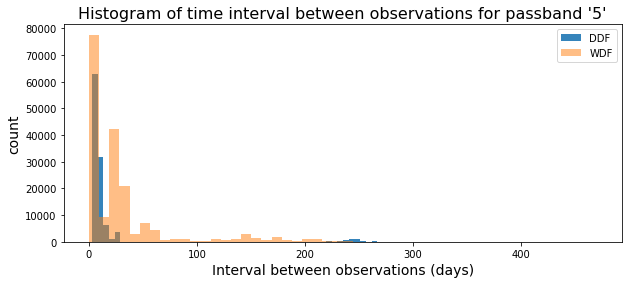

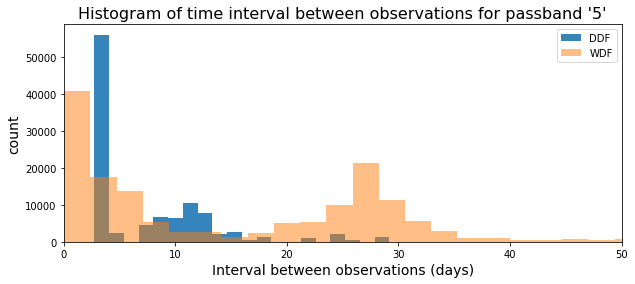

In [8]:
fig = plt.figure(figsize=(10, 4))
plt.hist(intervals_ddf, alpha=0.9, bins=50, label="DDF")
plt.hist(intervals_wdf, alpha=0.5, bins=50, label="WDF")
plt.xlabel("Interval between observations (days)", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.title("Histogram of time interval between observations for passband '%s'" % passband, fontsize=16)
_ = plt.legend()

fig = plt.figure(figsize=(10, 4))
plt.hist(intervals_ddf, alpha=0.9, bins=200, label="DDF")
plt.hist(intervals_wdf, alpha=0.5, bins=200, label="WDF")
plt.xlabel("Interval between observations (days)", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.xlim([0,50])
plt.title("Histogram of time interval between observations for passband '%s'" % passband, fontsize=16)
_ = plt.legend()

In [102]:
def get_bandwidths(times):
    res = []
    for ts_t in times:
        res.append(ts_t[-1] - ts_t[0])
    return res

bandwidths_ddf = get_bandwidths(t_ddf)
bandwidths_wdf = get_bandwidths(t_wdf)

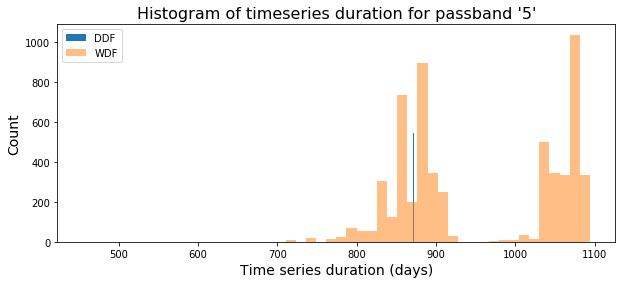

In [103]:
fig = plt.figure(figsize=(10, 4))
plt.hist(bandwidths_ddf, alpha=1, bins=50, label="DDF")
plt.hist(bandwidths_wdf, alpha=0.5, bins=50, label="WDF")
plt.xlabel("Time series duration (days)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Histogram of timeseries duration for passband '%s'" % passband, fontsize=16)
_ = plt.legend()

In [104]:
def get_total_samples(times):
    res = []
    for ts_t in times:
        res.append(len(ts_t))
    return res

total_samples_ddf = get_total_samples(t_ddf)
total_samples_wdf = get_total_samples(t_wdf)

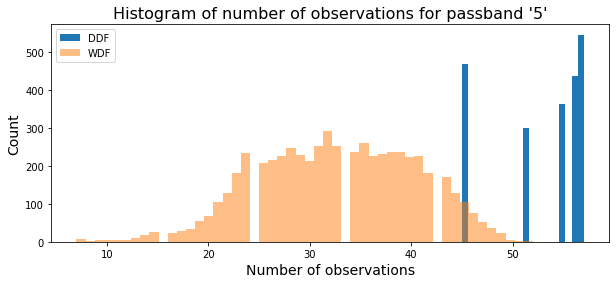

In [105]:
fig = plt.figure(figsize=(10, 4))
plt.hist(total_samples_ddf, alpha=1, bins=20, label="DDF")
plt.hist(total_samples_wdf, alpha=0.5, bins=50, label="WDF")
plt.xlabel("Number of observations", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Histogram of number of observations for passband '%s'" % passband, fontsize=16)
_ = plt.legend()

In [38]:
def get_total_multiband_samples(df_meta, df):
    df1 = df.sort_values(by=["object_id", "mjd"])
    df_count = df1.groupby("object_id")["flux"].count()
    counts = []
    for obj in df_meta["object_id"]:
        counts.append(df_count.loc[obj])
    return counts
    
count_samples_mb_ddf = get_total_multiband_samples(df_meta_ddf, df)
count_samples_mb_wdf = get_total_multiband_samples(df_meta_wdf, df)

In [39]:
print(len(count_samples_mb_wdf), len(count_samples_mb_ddf))

5732 2116


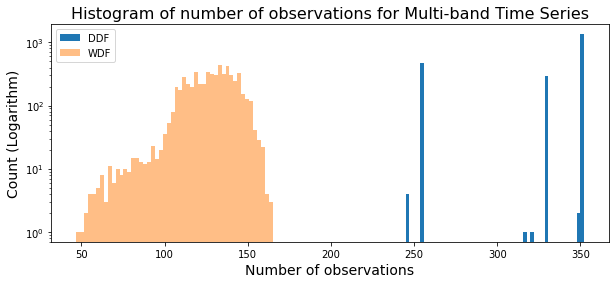

In [47]:
fig = plt.figure(figsize=(10, 4))
plt.hist(count_samples_mb_ddf, alpha=1, bins=50, label="DDF", log=True)
plt.hist(count_samples_mb_wdf, alpha=0.5, bins=50, label="WDF", log=True)
plt.xlabel("Number of observations", fontsize=14)
plt.ylabel("Count (Logarithm)", fontsize=14)
plt.title("Histogram of number of observations for Multi-band Time Series", fontsize=16)
_ = plt.legend()

In [7]:
def get_count_detection(df_meta, df):
    df1 = df.sort_values(by=["object_id", "mjd"])
    df1_groupby = df1.groupby("object_id")
    detections = df1_groupby["detected"].apply(list)
    count_detection = []
    for obj in df_meta["object_id"]:
        detections_obj = detections.loc[obj]
        count_detection.append(np.sum(detections_obj))
    return count_detection

count_detect_ddf = get_count_detection(df_meta_ddf, df)
count_detect_wdf = get_count_detection(df_meta_wdf, df)

In [9]:
len(count_detect_ddf)

2116

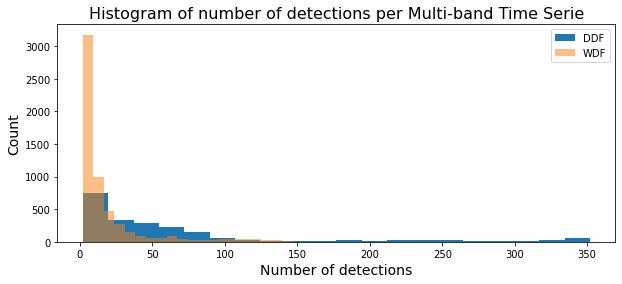

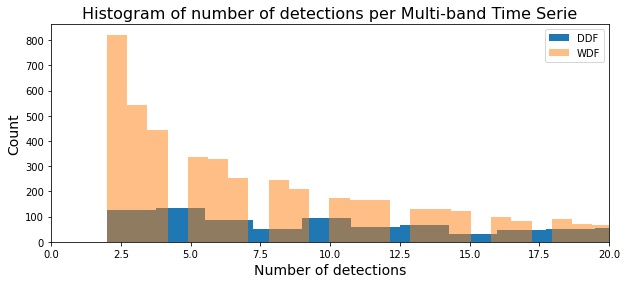

In [20]:
fig = plt.figure(figsize=(10, 4))
plt.hist(count_detect_ddf, alpha=1, bins=20, label="DDF")
plt.hist(count_detect_wdf, alpha=0.5, bins=20, label="WDF")
plt.xlabel("Number of detections", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Histogram of number of detections per Multi-band Time Serie", fontsize=16)
_ = plt.legend()


fig = plt.figure(figsize=(10, 4))
plt.hist(count_detect_ddf, alpha=1, bins=200, label="DDF")
plt.hist(count_detect_wdf, alpha=0.5, bins=200, label="WDF")
plt.xlim([0,20])
plt.xlabel("Number of detections", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Histogram of number of detections per Multi-band Time Serie", fontsize=16)
_ = plt.legend()

### Comments

- there are more WDF timeseries than DDF timeseries
- DDF timeseries has more observations than WDF timeseries
- DDF timeseries has lower timer intervals between observations
- classes 6, 15, 53 and  64 have less than 10 DDF timeseries
- classes 52, 67, 92, 95 have less than 100 DDF timeseries

### Working decision

- We will use classes (16, 42, 62, 65, 88, 90) for testing, discarding classes (6, 15, 52, 53, 64, 67, 92, 95). 
- We will split datasets in DDF and WDF datasets with 60% training and 40% test. 
- (optional for balancing) In addition, class 90 will be reduced to half in random way
- we will create 3 sizes dataset, using 30%, 50% and 100% of the data, in a stratify way

In [114]:
def get_reduced_stratify_dataset(dataset, labels, reduced_size, test_fraction):
    if len(dataset) - reduced_size > 10:
        _, dataset, _,  labels = train_test_split(dataset, labels,
                                                    test_size=reduced_size,
                                                    random_state=0,
                                                    stratify=labels)
    test_size = int(reduced_size * test_fraction)
    return train_test_split(dataset, labels, test_size=test_size, random_state=0, stratify=labels)

def generate_reduced_stratify_dataset(ddf_dtl, wdf_dtl, test_fraction, dataset_ratios, output_path):
    for d_ratio in dataset_ratios:
        for dtl_set, key in zip([ddf_dtl, wdf_dtl], ["ddf", "wdf"]):
            d = dtl_set[0]
            t = dtl_set[1]
            l = dtl_set[2]
            t_d = [(t, y) for t, y in zip(t, d)]
            size = int(len(d) * d_ratio)
            train_t_d, test_t_d, train_l, test_l = get_reduced_stratify_dataset(t_d, l, 
                                                                                size, 
                                                                                test_fraction)
            train_t, train_d = zip(*train_t_d)
            test_t, test_d = zip(*test_t_d)
            skip = False
            for type_i, data_i in zip(["d", "t", "l"],
                                  [(train_d, test_d), (train_t, test_t), (train_l, test_l)]):
                out_file_train = os.path.join(output_path, "{}_train_{}_size{}.npy".format(key, type_i, size))
                out_file_test = os.path.join(output_path, "{}_test_{}_size{}.npy".format(key, type_i, size))
                
                if not os.path.exists(out_file_train):
                    np.save(out_file_train, data_i[0])
                    np.save(out_file_test, data_i[1])
                else:
                    skip = True
                    break
            if not skip:
                print(":::GEN %s dataset of size %d [%d train, %d test] on dir:" % (key, size, len(train_d), 
                                                                                      len(test_d)))
                print("::: ", output_path)
            else:
                print(":::SKIP %s dataset of size %d" % (key, size))

In [119]:
test_fraction = 0.4
dataset_ratios = [0.3, 0.5, 1]
output_path_reduced = os.path.join(data_path, "plasticc_subsets", "ddf_wdf_split_simplified", "60_40_split")

df_meta_reduced = df_meta[df_meta["target"].isin([16, 42, 62, 65, 88, 90])]

wdf = 0
ddf = 1

df_meta_reduced_ddf = df_meta_reduced[df_meta_reduced["ddf"] == ddf]
df_meta_reduced_wdf = df_meta_reduced[df_meta_reduced["ddf"] == wdf]

passband = 5
d_ddf, t_ddf, l_ddf = get_timeseries(df, df_meta_reduced_ddf, passband=passband)
d_wdf, t_wdf, l_wdf = get_timeseries(df, df_meta_reduced_wdf, passband=passband)

generate_reduced_stratify_dataset([d_ddf, t_ddf, l_ddf], [d_wdf, t_wdf, l_wdf], 
                                  test_fraction, dataset_ratios, output_path_reduced)

:::GEN ddf dataset of size 558 [335 train, 223 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN wdf dataset of size 1321 [793 train, 528 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN ddf dataset of size 930 [558 train, 372 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN wdf dataset of size 2202 [1322 train, 880 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN ddf dataset of size 1860 [1116 train, 744 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN wdf dataset of size 4405 [2643 train, 1762 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split


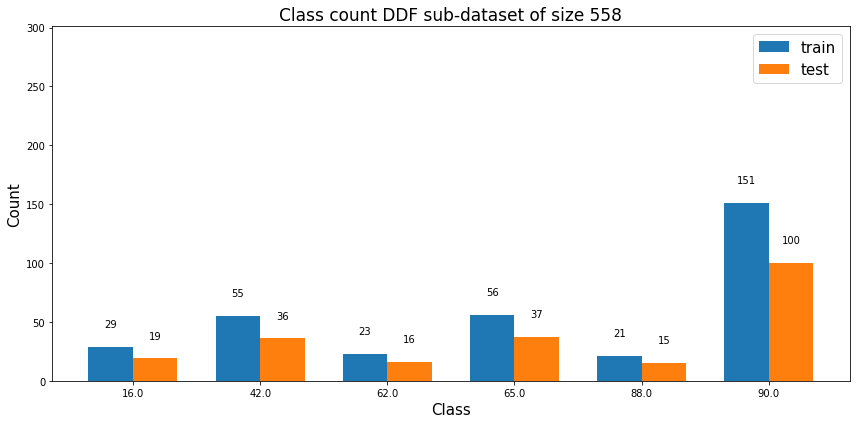

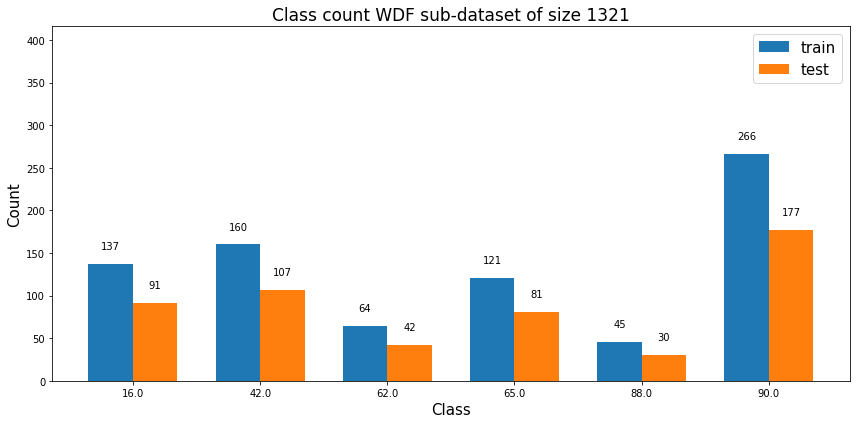

In [126]:
ddf_subset_train_l = np.load(os.path.join(output_path_reduced, "ddf_train_l_size558.npy"), allow_pickle=True)
ddf_subset_test_l = np.load(os.path.join(output_path_reduced, "ddf_test_l_size558.npy"), allow_pickle=True)
wdf_subset_train_l = np.load(os.path.join(output_path_reduced, "wdf_train_l_size1321.npy"), allow_pickle=True)
wdf_subset_test_l = np.load(os.path.join(output_path_reduced, "wdf_test_l_size1321.npy"), allow_pickle=True)

def fast_class_count_plot(train_l, test_l, title="Timeseries count per class"):
    class_count_train = defaultdict(int)
    for l in train_l:
        class_count_train[l] += 1
    class_count_test = defaultdict(int)
    for l in test_l:
        class_count_test[l] += 1
    
    plot_labels_tuple(class_count_train, class_count_test, "train", "test", title=title)
    
fast_class_count_plot(ddf_subset_train_l, ddf_subset_test_l, title="Class count DDF sub-dataset of size 558")
fast_class_count_plot(wdf_subset_train_l, wdf_subset_test_l, title="Class count WDF sub-dataset of size 1321")

## Detection Feature

we can see that original dataset includes a detection/non-detection feature and that most of the single-band time series has <3 detections, so we can create a single-band dataset using only time series with a minimum number of detections. The full dataset include objects that has at least 2 detection counting all bands

In [6]:
# we take time series with at least 'min_detections' detections in this band
def get_timeseries_detections(df, df_meta, passband=3, min_detections=3):
    df1 = df[df["passband"] == passband]
    df1 = df1.sort_values(by=["object_id", "mjd"])
    df_grouped = df1.groupby("object_id")
    fluxes = df_grouped["flux"].apply(list)
    mjds = df_grouped["mjd"].apply(list)
    detections = df_grouped["detected"].apply(list)
    labels = []
    dataset = []
    times = []
    total_detected = []
    ddf_target = []
    wdf_target = []
    
    for i in range(df_meta.shape[0]):
        row = df_meta.iloc[i]
        object_id = row.object_id
        target = row.target
        tot_detect = np.sum(detections.loc[object_id])
        if tot_detect >= min_detections:
            labels.append(target)
            dataset.append(np.array(fluxes.loc[object_id]))
            times.append(np.array(mjds.loc[object_id]))
            total_detected.append(tot_detect)
            
            if row.ddf:
                ddf_target.append(target)
            else:
                wdf_target.append(target)
                
    return dataset, times, labels, total_detected, ddf_target, wdf_target

passband = 5
d_before, t_before, l_before, total_detected, ddf_target, wdf_target = get_timeseries_detections(df, df_meta, passband=passband)

In [7]:
print(len(total_detected), len(ddf_target), len(wdf_target))

2402 1206 1196


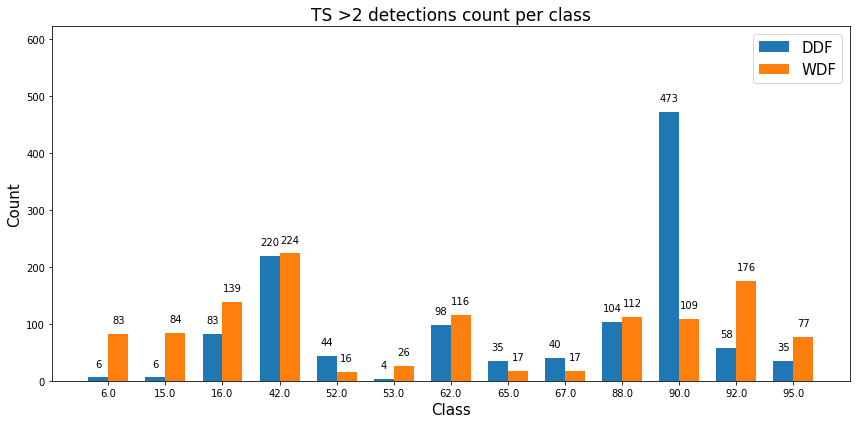

In [8]:
class_count_ddf = defaultdict(int)
for l in ddf_target:
    class_count_ddf[l] += 1

class_count_wdf = defaultdict(int)
for l in wdf_target:
    class_count_wdf[l] += 1
    
def plot_labels_tuple(class_count1, class_count2, label1, label2, title="Timeseries count per class"):
    labels_cc1, values_cc1 = zip(*sorted(class_count1.items()))
    labels_cc2, values_cc2 = zip(*sorted(class_count2.items()))
    
    indexes = np.arange(len(labels_cc1))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(indexes, values_cc1, width)
    rects2 = ax.bar(indexes + width, values_cc2, width)
    
    ax.set_xticks(indexes + width / 2)
    ax.set_ylim([0, max(np.max(values_cc1), np.max(values_cc2)) + 150])
    ax.set_xticklabels(labels_cc1)
    
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
    ax.legend((rects1[0], rects2[0]), (label1, label2), fontsize=15)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 15,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    
plot_labels_tuple(class_count_ddf, class_count_wdf, "DDF", "WDF", title="TS >2 detections count per class")

from this setup, we keep classes: 16, 42, 62, 88, 92

In [9]:
def get_reduced_stratify_dataset(dataset, labels, reduced_size, test_fraction):
    if len(dataset) - reduced_size > 10:
        _, dataset, _,  labels = train_test_split(dataset, labels,
                                                    test_size=reduced_size,
                                                    random_state=0,
                                                    stratify=labels)
    test_size = int(reduced_size * test_fraction)
    return train_test_split(dataset, labels, test_size=test_size, random_state=0, stratify=labels)

def generate_reduced_stratify_dataset(ddf_dtl, wdf_dtl, test_fraction, dataset_ratios, output_path):
    for d_ratio in dataset_ratios:
        for dtl_set, key in zip([ddf_dtl, wdf_dtl], ["ddf", "wdf"]):
            d = dtl_set[0]
            t = dtl_set[1]
            l = dtl_set[2]
            t_d = [(t, y) for t, y in zip(t, d)]
            size = int(len(d) * d_ratio)
            train_t_d, test_t_d, train_l, test_l = get_reduced_stratify_dataset(t_d, l, 
                                                                                size, 
                                                                                test_fraction)
            train_t, train_d = zip(*train_t_d)
            test_t, test_d = zip(*test_t_d)
            skip = False
            for type_i, data_i in zip(["d", "t", "l"],
                                  [(train_d, test_d), (train_t, test_t), (train_l, test_l)]):
                out_file_train = os.path.join(output_path, "{}_train_{}_size{}.npy".format(key, type_i, size))
                out_file_test = os.path.join(output_path, "{}_test_{}_size{}.npy".format(key, type_i, size))
                
                if not os.path.exists(out_file_train):
                    np.save(out_file_train, data_i[0])
                    np.save(out_file_test, data_i[1])
                else:
                    skip = True
                    break
            if not skip:
                print(":::GEN %s dataset of size %d [%d train, %d test] on dir:" % (key, size, len(train_d), 
                                                                                      len(test_d)))
                print("::: ", output_path)
            else:
                print(":::SKIP %s dataset of size %d" % (key, size))

In [13]:
def get_timeseries_detected(df, df_meta, passband=3, min_detections=3):
    df1 = df[df["passband"] == passband]
    df1 = df1.sort_values(by=["object_id", "mjd"])
    df_grouped = df1.groupby("object_id")
    fluxes = df_grouped["flux"].apply(list)
    mjds = df_grouped["mjd"].apply(list)
    detections = df_grouped["detected"].apply(list)
    labels = []
    dataset = []
    times = []
    total_detected = []
    
    for i in range(df_meta.shape[0]):
        row = df_meta.iloc[i]
        object_id = row.object_id
        target = row.target
        tot_detect = np.sum(detections.loc[object_id])
        if tot_detect >= min_detections:
            labels.append(target)
            dataset.append(np.array(fluxes.loc[object_id]))
            times.append(np.array(mjds.loc[object_id]))
            total_detected.append(tot_detect)
                
    return dataset, times, labels, total_detected

def get_stratify_dataset(dataset, labels, test_fraction):
    test_size = int(len(dataset) * test_fraction)
    return train_test_split(dataset, labels, test_size=test_size, random_state=0, stratify=labels)

def gen_dataset_min_detection(df, df_meta, output_path, min_detect=5, passband=5):
#     df_meta_reduced2 = df_meta[df_meta["target"].isin([16, 42, 62, 88, 92])]
    df_meta_reduced2 = df_meta

    wdf = 0
    ddf = 1
    
    datasets = []

    for ddf in [1, 0]:
        if ddf == 1:
            key = "ddf"
        else:
            key = "wdf"
        df_meta_reduced2_type = df_meta_reduced2[df_meta_reduced2["ddf"] == ddf]
        
        d, t, l, _ = get_timeseries_detected(df, df_meta_reduced2_type, passband=passband, min_detections=min_detect)
#         t_d = [(t, y) for t, y in zip(t, d)]
    
#         train_t_d, test_t_d, train_l, test_l = get_stratify_dataset(t_d, l, 0.4)
    
#         train_t, train_d = zip(*train_t_d)
#         test_t, test_d = zip(*test_t_d)
#         datasets.append([train_d, test_d, train_t, test_t, train_l, test_l])
        skip = False
#         for type_i, data_i in zip(["d", "t", "l"],
#                                   [(train_d, test_d), (train_t, test_t), (train_l, test_l)]):
#             out_file_train = os.path.join(output_path, "{}_train_{}.npy".format(key, type_i))
#             out_file_test = os.path.join(output_path, "{}_test_{}.npy".format(key, type_i))
#                 
#             if not os.path.exists(out_file_train):
#                 np.save(out_file_train, data_i[0])
#                 np.save(out_file_test, data_i[1])
#             else:
#                 skip = True
#                 break
        for type_i,  data_i in zip(["dataset", "times", "labels"], [d, t, l]):
            out_file = os.path.join(output_path, "{}_{}.npy".format(key, type_i))
            if not os.path.exists(out_file):
                np.save(out_file, data_i)
            else:
                skip = True
                break
                
        if not skip:
            print(":::GEN %s dataset of size %d on dir:" % (key, len(d)))
            print("::: ", output_path)
        else:
            print(":::SKIP %s dataset of size %d" % (key, len(d)))
    return datasets
        
output_path_min_detect = os.path.join(data_path, "plasticc_subsets", "ddf_wdf_split_min_detection", "5_min")
datases_gen = gen_dataset_min_detection(df, df_meta, output_path_min_detect, min_detect=3, passband=5)

:::GEN ddf dataset of size 1206 on dir:
:::  /home/frmunoz/Documents/tesis/notebooks/../data/plasticc_subsets/ddf_wdf_split_min_detection/5_min
:::GEN wdf dataset of size 1196 on dir:
:::  /home/frmunoz/Documents/tesis/notebooks/../data/plasticc_subsets/ddf_wdf_split_min_detection/5_min


In [19]:
gen_test_d = np.load("/home/frmunoz/Documents/tesis/data/plasticc_subsets/ddf_wdf_split_min_detection/3_min/ddf_test_d.npy", allow_pickle=True)
gen_test_t = np.load("/home/frmunoz/Documents/tesis/data/plasticc_subsets/ddf_wdf_split_min_detection/3_min/ddf_test_t.npy", allow_pickle=True)

In [20]:
for t, d in zip(gen_test_t, gen_test_d):
    if len(t) != len(d):
        print(len(t), len(d))

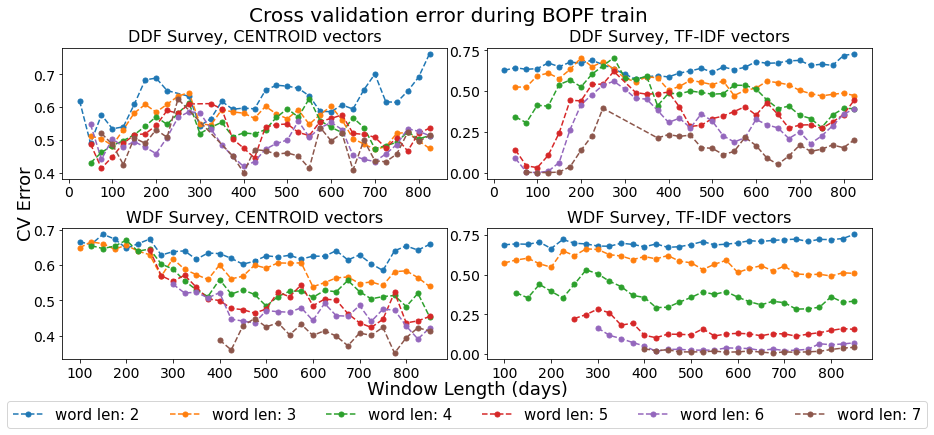

In [252]:
results_main_path = "/home/frmunoz/Documents/tesis/data/plasticc_subsets/ddf_wdf_split_min_detection/3_min/bopf_classification_reports/"
fig, ax = plt.subplots(2, 2, figsize=(14, 6))
i = 0
for key in ["ddf", "wdf"]:
    df_test = pd.read_csv(results_main_path + "output_dict_%s.csv" % key)
    df_test = df_test.sort_values(by=["bop_wd", "bop_wl"])
    df_test_grouped = df_test.groupby(["bop_wd"])
    cv_acc1 = df_test_grouped["bop_cv_acc"].apply(list)
    cv_acc2 = df_test_grouped["bop_cv_acc2"].apply(list)
    wl = df_test_grouped["bop_wl"].apply(list)
    j = 0
    for key2, cv_acc in zip(["Centroid", "TF-IDF"], [cv_acc1, cv_acc2]):
        for wd in range(2, 8):
            cv_acc_wd = 1 - np.array(cv_acc.loc[wd])
            wl_wd = wl.loc[wd]
            ax[i][j].plot(wl_wd, cv_acc_wd, "o--", label="word len: %d" % wd, markersize=5)
#             plt.annotate("wd=%d" % wd, xy=(wl_wd[-1],cv_acc_wd[-1]), xytext=(5,0), textcoords='offset points', va='center')
#         ax[i][j].legend(fontsize=16)
#         ax[i][j].set_xlabel("Window Length (days)", fontsize=22)
#         ax[i][j].set_ylabel("Cross Validation Accuracy", fontsize=22)
        ax[i][j].set_title("%s Survey, %s vectors" % (key.upper(), key2.upper()), fontsize=16)
        ax[i][j].xaxis.set_tick_params(labelsize=14)
        ax[i][j].yaxis.set_tick_params(labelsize=14)
        j += 1
    i += 1
        
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Window Length (days)", fontsize=18)
plt.ylabel("CV Error", fontsize=18)
fig.suptitle("Cross validation error during BOPF train", fontsize=20)
fig.subplots_adjust(top=0.2)

axi = ax[1][0]
# box = axi.get_position()
# axi.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# # Put a legend below current axis
# axi.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
#           fancybox=True, shadow=True, ncol=6)

# print(axi.get_legend_handles_labels())

plt.legend(*axi.get_legend_handles_labels(), loc="upper center", 
           bbox_to_anchor=(0.5, -0.11), ncol=6, fontsize=15)


plt.tight_layout()
plt.savefig(results_main_path + "cv_err_train.png", dpi=300)

centroid ddf 6 0.5914357381748686
2 0.5 5 6 purple
3 0.5 5 6 orange
4 0.5 5 6 brown
5 0.5 5 6 green
6 1 7 6 blue
7 0.5 5 6 red
centroid wdf 5 0.5157919448515443
4 0.5 5 5 brown
5 1 7 5 green
6 0.5 5 5 blue
7 0.5 5 5 red
tf_idf ddf 7 0.5921346769172857
4 0.5 5 7 brown
5 0.5 5 7 green
6 0.5 5 7 blue
7 1 7 7 red
tf_idf wdf 4 0.5027262505718783
4 1 7 4 brown
5 0.5 5 4 green
6 0.5 5 4 blue
7 0.5 5 4 red


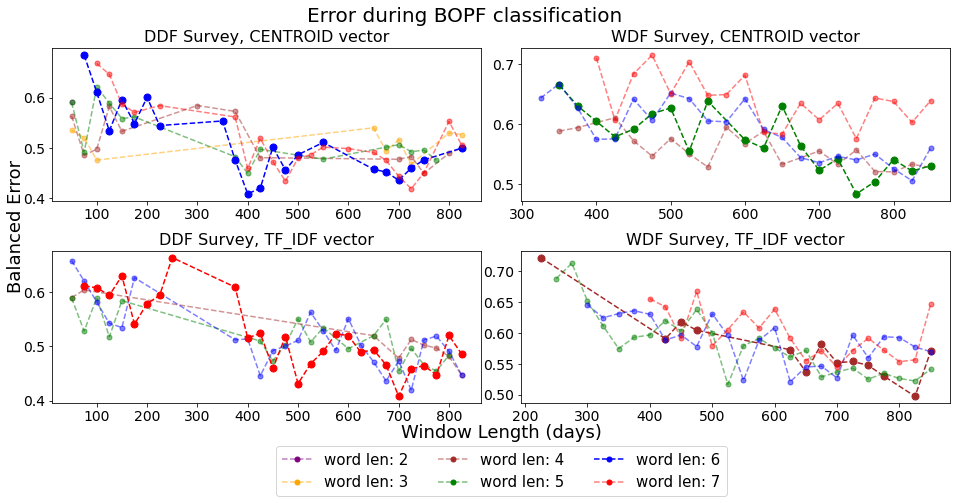

In [249]:
results_main_path = "/home/frmunoz/Documents/tesis/data/plasticc_subsets/ddf_wdf_split_min_detection/3_min/bopf_classification_reports/"

wd_colors = {2: "purple", 3: "orange", 4: "brown", 5: "green", 6: "blue", 7: "red"}
axi = None
fig, ax = plt.subplots(2, 2, figsize=(14, 7))
j = 0
for key2 in ["centroid", "tf_idf"]:
    i = 0
    for key in ["ddf", "wdf"]:
        df_test1 = pd.read_csv(results_main_path + "output_dict_test_%s_%s.csv" % (key2, key))
        main_min = df_test1["balanced_acc"].idxmax
        wds = df_test1["bop_wd"]
        main_wd_min = wds[main_min]
        print(key2, key, main_wd_min, df_test1["balanced_acc"][main_min])
#     df_test2 = pd.read_csv(results_main_path + "output_dict_test_tf_idf_%s.csv" % key)
        df_test1 = df_test1.sort_values(by=["bop_wd", "bop_wl"])
#     df_test2 = df_test.sort_values(by=["bop_wd", "bop_wl"])
        df_test_grouped1 = df_test1.groupby(["bop_wd"])
#     df_test_grouped2 = df_test2.groupby(["bop_wd"])
        bacc1 = df_test_grouped1["balanced_acc"].apply(list)
#     bacc2 = df_test_grouped2["balanced_acc"].apply(list)
        wl1 = df_test_grouped1["bop_wl"].apply(list)
#     wl2 = df_test_grouped2["bop_wl"].apply(list)
#         j = 0
        for wd in np.unique(wds):
            c_wd = 1 - np.array(bacc1.loc[wd])
            alpha = 0.5
            markersize = 5
            if wd == main_wd_min:
                alpha = 1
                markersize = 7
            print(wd, alpha, markersize, main_wd_min, wd_colors[wd])
            wl_wd = wl1.loc[wd]
            ax[j][i].plot(wl_wd, c_wd, "o--", color=wd_colors[wd], label="word len: %d" % wd, alpha=alpha, markersize=markersize)
#             plt.annotate("wd=%d" % wd, xy=(wl_wd[-1],cv_acc_wd[-1]), xytext=(5,0), textcoords='offset points', va='center')
#         ax[i][j].legend(fontsize=16)
#         ax[i][j].set_xlabel("Window Length (days)", fontsize=22)
#         ax[i][j].set_ylabel("Cross Validation Accuracy", fontsize=22)
            ax[j][i].set_title("%s Survey, %s vector" % (key.upper(), key2.upper()), fontsize=16)
            ax[j][i].xaxis.set_tick_params(labelsize=14)
            ax[j][i].yaxis.set_tick_params(labelsize=14)
        i += 1
    
    j += 1
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Window Length (days)", fontsize=18)
plt.ylabel("Balanced Error", fontsize=18)
fig.suptitle("Error during BOPF classification", fontsize=20)
fig.subplots_adjust(top=0.3)
if axi is None:
    axi = ax[0][0]
# box = axi.get_position()
# axi.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# # Put a legend below current axis
# axi.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
#           fancybox=True, shadow=True, ncol=6)

# print(axi.get_legend_handles_labels())
if key2 == "tf_idf":
    leg = plt.legend(*axi.get_legend_handles_labels(), loc="upper center", 
           bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=15)
        
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
        lh._legmarker.set_markersize(5)


plt.tight_layout()
plt.savefig(results_main_path + "error_test_bopf.png", dpi=300)

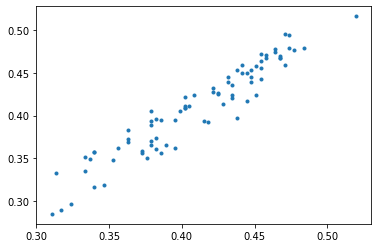

In [199]:
df_test = pd.read_csv(results_main_path + "output_dict_test_centroid_%s.csv" % (key))
#     df_test2 = pd.read_csv(results_main_path + "output_dict_test_tf_idf_%s.csv" % key)
df_test = df_test.sort_values(by=["bop_wd", "bop_wl"])
    
plt.figure()
plt.plot(df_test["acc"], df_test["balanced_acc"], '.')

#### Multi-band extension

for this case we will create a single dataset and split will be done in future applications. For compact data we will use pickle

In [27]:
def get_timeseries_detected_mb(df, df_meta, min_detections=3):
#     df1 = df[df["passband"] == passband]
    df1 = df.sort_values(by=["object_id", "mjd"])
    df_grouped = df1.groupby("object_id")
    sizes = df_grouped.size()
    fluxes = df_grouped["flux"].apply(list)
    mjds = df_grouped["mjd"].apply(list)
    detections = df_grouped["detected"].apply(list)
    bands = df_grouped["passband"].apply(list)
    
    labels = []
    dataset = []
    
    for i in range(df_meta.shape[0]):
        row = df_meta.iloc[i]
        object_id = row.object_id
        target = row.target
        data_obj = {}
        if np.sum(detections.loc[object_id]) >= min_detections:
            data_obj["flux"] = np.array(fluxes.loc[object_id], dtype=float)
            data_obj["mjd"] = np.array(mjds.loc[object_id], dtype=float)
            data_obj["band"] = np.array(bands.loc[object_id], dtype=int)
            data_obj["detected"] = np.array(detections.loc[object_id], dtype=int)
            labels.append(target)
            dataset.append(data_obj)
                
    return dataset, labels
def gen_multiband_dataset(df, df_meta, output_path, min_detections=3):
    df_meta_reduced2 = df_meta[df_meta["target"].isin([16, 42, 62, 88, 92])]
    
    for ddf, key in enumerate(["wdf", "ddf"]):
        df_meta_key = df_meta_reduced2[df_meta_reduced2["ddf"] == ddf]
        mb_dataset, labels = get_timeseries_detected_mb(df, df_meta_key, min_detections=min_detections)
        
        out_file_dataset = os.path.join(output_path, "mb_dataset_{}.npy".format(key))
        out_file_labels = os.path.join(output_path, "mb_labels_{}.npy".format(key))
        
        pickle.dump(mb_dataset, open(out_file_dataset, "wb"), -1)
        pickle.dump(labels, open(out_file_labels, "wb"), -1)
        
        print(":: GEN multi-band dataset of size %d for key: %s" % (len(labels), key))

In [28]:
output_path_min_detect_mb = os.path.join(data_path, "plasticc_subsets", 
                                         "ddf_wdf_split_min_detection", "3_min_mb")
gen_multiband_dataset(df, df_meta, output_path_min_detect_mb)

:: GEN multi-band dataset of size 2223 for key: wdf
:: GEN multi-band dataset of size 764 for key: ddf


## reduction: number of classes

as a first preprocessing step, we will discard every class with less than a fixed number of time series in order to make a more simplest dataset for testing reducing the number of classes with small amount of train and test data

In [10]:
threshold = 400
df_meta = df_meta.sort_values(by=["target"])
df_meta_filtered = df_meta[df_meta['target'].map(df_meta['target'].value_counts()) >= threshold]
classes = np.unique(df_meta_filtered["target"])
print("surviving classes are:", classes)
df_meta_filtered.shape[0]

surviving classes are: [15 16 42 62 65 90]


6390

we take time series fro the passband '3'

In [11]:
passband_id = 3

df = df[df["passband"] == passband_id]
df = df.sort_values(by=["object_id", "mjd"])
df_grouped = df.groupby("object_id")
fluxes = df_grouped["flux"].apply(list)
mjds = df_grouped["mjd"].apply(list)
labels = []
dataset = []
times = []
for i in range(df_meta_filtered.shape[0]):
    row = df_meta_filtered.iloc[i]
    object_id = row.object_id
    target = row.target
    labels.append(target)
    dataset.append(np.array(fluxes.loc[object_id]))
    times.append(np.array(mjds.loc[object_id]))

### Second reduction: train/test data size

since at first we will use non-optimize solutions which will take lot of time to execute, we will start evaluating our experimentes on small sub-sets from the original dataset. From here, we will test three scenarios:

1. constant train/test set ratio but increasing the number of timeseries
2. constant test set size but increasing the size of train set
3. constant train set size but increasing the size of the test set

in particular here, for the 3rd scenario we will just have to fix the train set size and get a test size as big as posible, then on evaluation process we will take only sub-sets of this test set

for the 2nd scenario, we will fix the test set size on 1/3 of the maximum train set size

In [12]:
def get_small_dataset(dataset, times, labels, n1, n2):
    # n: size of the small dataset
    # c: use the 'c' classes most present in the original dataset
    
    data_time_tuple = [(t, y) for t, y in zip(times, dataset)]
    
    # first split, to get n1+n2 set size
    if n1+n2 < len(labels) - np.unique(labels).size:
    
         _, data_time_tuple, _,  labels = train_test_split(data_time_tuple, labels,
                                                    test_size=n1 + n2,
                                                    random_state=0,
                                                    stratify=labels)
        
    # second split, to get train n1 and test n2
    data_time_train, data_time_test, labels_train, labels_test = train_test_split(data_time_tuple,
                                                                                 labels,
                                                                                 test_size=n2,
                                                                                 random_state=0,
                                                                                 stratify=labels)
    d_train = []
    d_test = []
    t_train = []
    t_test = []
    for i in range(n1):
        t, d = data_time_train[i]
        d_train.append(d)
        t_train.append(t)
        
    for i in range(n2):
        t, d = data_time_test[i]
        d_test.append(d)
        t_test.append(t)

    
    return d_train, t_train, labels_train, d_test, t_test, labels_test


def gen_sub_sets(output_path, dataset, times, labels, n1_arr, n2_arr, c):
    for n1, n2 in zip(n1_arr, n2_arr):
        d_train, t_train, l_train, d_test, t_test, l_test = get_small_dataset(dataset, times, labels,
                                                                             n1, n2)
        skip = False
        for type_i, data_i in zip(["d", "t", "l"],
                                  [(d_train, d_test), (t_train, t_test), (l_train, l_test)]):
            out_file_train = os.path.join(output_path, "train_{}_n{}_c{}.npy".format(type_i, n1, c))
            out_file_test = os.path.join(output_path, "test_{}_n{}_c{}.npy".format(type_i, n2, c))
            if not os.path.exists(out_file_train):
                np.save(out_file_train, data_i[0])
                np.save(out_file_test, data_i[1])
            else:
                skip = True
                break
        if not skip:
            print(":::GEN [train, test, classes] = [%d, %d, %d] set on dir %s" % (n1, n2, c, output_path))
        else:
            print(":::SKIP [train, test, classes] = [%d, %d, %d]" % (n1, n2, c))

In [15]:
# 1st scenario
ratio = 2/8 # 20% test, 80% train
n1_arr = np.array([100, 500, 1000, 2000, 4000, 5000], dtype=int)
n2_arr = (n1_arr * ratio).astype(int)
output_path1 = os.path.join(data_path, "plasticc_subsets", "scenario1_ratio_2-8")
gen_sub_sets(output_path1, dataset, times, labels, n1_arr, n2_arr, len(classes))

:::GEN [train, test, classes] = [100, 25, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [500, 125, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [1000, 250, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [2000, 500, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [4000, 1000, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [5000, 1250, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8


In [15]:
#2nd scenario

In [16]:
#3rd scenario